In [1]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity as cosine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from neo4j import GraphDatabase
import cv2
from glob import glob
import json

In [2]:
URI = "neo4j://localhost:7687"  
USERNAME = "neo4j"            
PASSWORD = "Tai123321"     

In [3]:
def get_neo4j_driver():
    return GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

In [4]:
def query_images_any(sorted_classes):
    image_ids = []
    with get_neo4j_driver().session() as session:
                query = """
                    WITH $classes AS classes
                    MATCH (img:Image)
                    WHERE ANY(class IN classes WHERE class IN[(img)-[:HAS_A]->(cls:Class) | cls.name])
                    RETURN img.image_Id AS image_id
                """
                result = session.run(query, classes=list(sorted_classes))
                for record in result:
                    if record["image_id"] not in image_ids:
                        image_ids.append(record["image_id"])
    if image_ids:
        return image_ids
    else:
        return None

In [5]:
bovw = json.load(open("./new_bovw.json"))
print(len(bovw))

97273


In [6]:
def get_image_profile_from_bovw(image_id, sorted_classes, tmp_bovw):
    for image in tmp_bovw:
        if image["ID"] == image_id:
            conf = 0
            for obj in image["Objects"]:
                if obj["Class"] in sorted_classes and obj["Conf"] > conf:
                    conf = obj["Conf"]
            histogram = image["Histogram"]
            #convert histogram to a list from a string
            histogram = histogram[1:-1].split(",")
            histogram = [float(i) for i in histogram]
            image_profile = {
                "ID": image["ID"],
                "features": histogram,
                "conf": conf
            }
            return image_profile
        
def get_image_histogram(image_id):
    for image in bovw:
        if image["ID"] == image_id:
            return image["Histogram"]
    return None

def compute_histogram(image_path, bins=8):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Split into B, G, R channels
    channels = cv2.split(image)

    # Empty list to store histogram values
    hist = []

    # Compute histogram for each channel
    for channel in channels:
        channel_hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])
        # Normalize to range [0, 1]
        cv2.normalize(channel_hist, channel_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        # Flatten and add to the list
        hist.extend(channel_hist.flatten())

    return hist

In [7]:
def calculate_cosine_similarity(a, b):
    #use scikit-learn cosine_similarity
    a = np.array(a).reshape(1, -1)
    b = np.array(b).reshape(1, -1)
    return cosine(a, b)[0][0]

def combine_scoring(input_image_histogram, output_img_profile, weightConf=0.7, weightHist=0.3):
    # Calculate the cosine similarity between the based image and the output image
    cosine_sim = calculate_cosine_similarity(input_image_histogram, output_img_profile["features"])
    
    # Combine the confidence score and cosine similarity
    combined_score = weightConf * output_img_profile["conf"] + weightHist * cosine_sim
    
    return combined_score

In [8]:
import ast
ground_truth = pd.read_csv("./pre_re_cal/ground_truth_top_level.csv")

In [9]:
ground_truth["Description"] = ground_truth["Description"].apply(ast.literal_eval)
ground_truth["Top Level Classes"] = ground_truth["Top Level Classes"].apply(ast.literal_eval)

In [10]:
print(ground_truth.head())

            ImageID                                        Description  \
0  0000253ea4ecbf19  [Carnivore, Human leg, Mammal, Plant, Tree, Hu...   
1  0000271195f2c007  [Human eye, Headphones, Boy, Person, Human mou...   
2  0000286a5c6a3eb5  [Human eye, Sunglasses, Shorts, Person, Human ...   
3  00003bfccf5f36c2  [Person, Lantern, Chair, Table, Tree, Furnitur...   
4  000045257f66b9e2  [Boy, Person, Cowboy hat, Hat, Fedora, Human b...   

                                   Top Level Classes  
0                [Plant, Mammal, Animal, Human body]  
1         [Headphones, Person, Human body, Clothing]  
2  [Human body, Clothing, Person, Animal, Persona...  
3  [Window, Lantern, Furniture, Plant, Building, ...  
4  [Human body, Hat, Clothing, Trousers, Plant, F...  


In [11]:
child_map = pd.read_csv("./pre_re_cal/child_map.csv")
print(child_map.head())

        Parent                                              Child
0     Aircraft               ['Helicopter', 'Airplane', 'Rocket']
1       Animal  ['Shellfish', 'Bird', 'Invertebrate', 'Mammal'...
2    Auto part  ['Vehicle registration plate', 'Wheel', 'Seat ...
3  Baked goods  ['Pretzel', 'Cookie', 'Muffin', 'Bagel', 'Brea...
4         Ball  ['Football', 'Cricket ball', 'Volleyball (Ball...


In [12]:
child_map["Child"] = child_map["Child"].apply(ast.literal_eval)

In [13]:
def get_child_classes(parent_class):
    child_classes = []
    child_classes.append(parent_class)
    for index, row in child_map.iterrows():
        if row["Parent"] == parent_class:
            child_classes.extend(row["Child"])
    return child_classes

In [41]:
def check_if_image_is_right(image_id, parent_class, copy_ground_truth):
    # Find rows where the ImageID matches
    matching_rows = copy_ground_truth[copy_ground_truth["ImageID"] == image_id]

    if not matching_rows.empty:
        # Check if the parent_class is in the "Top Level Classes" column
        if parent_class in matching_rows.iloc[0]["Top Level Classes"]:
            # Drop the matching row
            copy_ground_truth.drop(matching_rows.index[0], inplace=True)
            return 1
        else:
            # Drop the matching row
            copy_ground_truth.drop(matching_rows.index[0], inplace=True)
            return 0

    return 0

In [25]:
def get_image_id(image_path):
    return image_path.split("/")[-1].split(".")[0].split("\\")[-1]

In [39]:
def get_top_k_images(input_image_path, cls, top_k=1000):
    # child_classes = get_child_classes(cls)
    child_classes = [cls]
    image_ids = query_images_any(child_classes)
    input_image_id = get_image_id(input_image_path)
    if image_ids is None:
        return None
    else:
        print(len(image_ids))
        image_profiles = []
        input_image_histogram = compute_histogram(input_image_path)
        tmp_bovw = bovw.copy()
        copy_ground_truth = ground_truth.copy()
        i = 0
        for image_id in image_ids:
            if image_id != input_image_id:
                image_profile = get_image_profile_from_bovw(image_id, child_classes, tmp_bovw)
                if image_profile is not None:
                    combined_score = combine_scoring(input_image_histogram, image_profile)
                    # Check if the image is in the ground truth
                    parent_class = cls
                    is_right = check_if_image_is_right(image_id, parent_class, copy_ground_truth)
                    print(f"{i}. Image ID: {image_profile['ID']}, Combined Score: {combined_score}, Is Right: {is_right}")
                    image_profiles.append((image_profile, combined_score, is_right))
                    i += 1
        # Sort the images based on the combined score
        sorted_images = sorted(image_profiles, key=lambda x: x[1], reverse=True)
        # Get the top k images
        # top_k_images = sorted_images[:top_k]
        # return top_k_images
        return sorted_images

In [34]:
def get_y_true_and_y_scores(single_cls, image_ids):
    y_true = []
    y_scores = []
    for image_id, score in image_ids:
        # Check if the image is in the ground truth
        if check_if_image_is_right(image_id, single_cls) == 1:
            y_true.append(1)
        else:
            y_true.append(0)
        print(f"Image ID: {image_id}, Score: {score}, True Label: {y_true[-1]}")
        y_scores.append(score)
    return y_true, y_scores

In [17]:
from glob import glob

In [18]:
classes = ['Person', 'Clothing', 'Plant', 'Human body', 'Tree', 'Vehicle', 'Building', 'Land vehicle', 'Animal', 'Footwear']

In [19]:
image_paths = glob("./open_images_classes_1/Person/images/val/*.jpg")

In [20]:
image_id_test = image_paths[0].split("/")[-1].split(".")[0].split("\\")[-1]
print(image_id_test)

01ab773186c630c4


In [42]:
list_top_k = []
for image_path in image_paths:
    image_id = get_image_id(image_path)
    print(f"Processing image {image_id}")
    # Get the top k images for each class
    top_k_images = get_top_k_images(image_path, "Person", top_k=1000)
    list_top_k.append(top_k_images)
    break


Processing image 01ab773186c630c4
18062
0. Image ID: 1077a7f431ff3ab7, Combined Score: 0.6050518259726683, Is Right: 0
1. Image ID: 04ebdcef386f13eb, Combined Score: 0.5228553456027474, Is Right: 1
2. Image ID: 31705f96656f6e59, Combined Score: 0.5107547453382753, Is Right: 0
3. Image ID: 23ff74609a6be175, Combined Score: 0.10150185248496534, Is Right: 1
4. Image ID: 7e1763cbe45ebbdd, Combined Score: 0.3059744096935286, Is Right: 1
5. Image ID: 58dd030627375df7, Combined Score: 0.3273219737697657, Is Right: 1
6. Image ID: 4cd5dd68dd90cf9f, Combined Score: 0.6325486932039213, Is Right: 1
7. Image ID: 03a1abdb0b26c102, Combined Score: 0.3868196532399223, Is Right: 0
8. Image ID: 0933933417e88166, Combined Score: 0.6328450146057716, Is Right: 0
9. Image ID: b40deb604b59742b, Combined Score: 0.5314267436465169, Is Right: 1
10. Image ID: 09897837c6ab35c0, Combined Score: 0.4708040089370342, Is Right: 1
11. Image ID: 9a66c83e1f0afd00, Combined Score: 0.3640673909460048, Is Right: 1
12. Image

In [47]:
test_score = []
test_true = []
for top_k_images in list_top_k:
    for image_profile, score, is_right in top_k_images:
        test_score.append(score)
        test_true.append(is_right)
print(len(test_score))
print(len(test_true))

18062
18062


In [52]:
len_imgs_in_db = len(pd.read_csv("./bowv/export.csv"))
print(len_imgs_in_db)

97273


In [51]:
len(ground_truth)

105185

In [53]:
#adding test_score = 0 and true_score = 0 till the length of the ground truth
copy_test_score = test_score.copy()
copy_test_true = test_true.copy()
for i in range(len_imgs_in_db - len(test_score)):
    copy_test_score.append(0)
    copy_test_true.append(0)

In [61]:
fpr, tpr, roc_thresholds = roc_curve(test_true, test_score)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(test_true, test_score)
average_precision = average_precision_score(test_true, test_score)

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"ROC Thresholds: {roc_thresholds}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"PR Thresholds: {pr_thresholds}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {average_precision}")


FPR: [0.        0.        0.        ... 0.9995583 1.        1.       ]
TPR: [0.00000000e+00 6.32991518e-05 4.05114571e-03 ... 9.99873402e-01
 9.99873402e-01 1.00000000e+00]
ROC Thresholds: [       inf 0.84059613 0.76963596 ... 0.02790555 0.02246739 0.01687667]
Precision: [0.87465397 0.87464703 0.87464009 ... 1.         1.         1.        ]
Recall: [1.00000000e+00 9.99936701e-01 9.99873402e-01 ... 1.26598304e-04
 6.32991518e-05 0.00000000e+00]
PR Thresholds: [0.01687667 0.01950075 0.02246739 ... 0.83005886 0.83097108 0.84059613]
ROC AUC: 0.5664820590520695
Average Precision: 0.9045064035948216


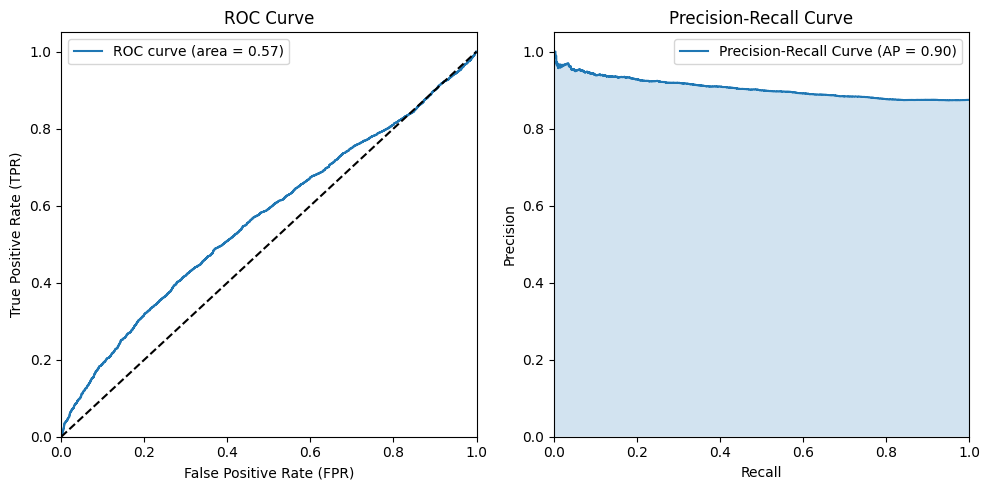

In [62]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precision-Recall Curve (AP = {average_precision:.2f})")
plt.fill_between(recall, precision, alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()